# WB3 - Predictive Modelling

## Table of Contents

* [1. Import Libraries and Data](#Import)
* [2. Data Preparatioin](#Preparation)
    * [Standardisation](#Standardisation)
    * [Outliers](#Outliers)
    * [Encoding Categorical Variables](#Encoding)
    * [Data Splitting](#Splitting)
* [3. Linear Regression](#Linear)
* [4. Regression Tree](#RegressionTree)
* [5. Random Forest](#RandomForest)
* [6. AdaBoost](#AdaBoost)
* [7. Gradient Boosting Regression Trees (GBRT)](#GBRT)
* [8. XGBoost](#XGBoost)
* [9. Support Vector Regressor (SVR)](#SVR)
* [10. Comparison of Initial Models](#Initial)
* [11. Optimal Hyperparameters Found](#Hyperparameters)
* [12. Comparison of Final Model Performances](#Final)
* [13. Linear Regression Coefficients](#Coefficients)
* [14. Feature Importance Analysis](#Feature)

# 1. Import Libraries and Data<a class="anchor" id="Import"></a>

In this step, we import the necessary libraries and modules that will be used throughout the predictive modeling process. These libraries include NumPy, Pandas, Matplotlib, Seaborn, and various machine learning modules from Scikit-learn and Statsmodels. We also read the preprocessed data from the 'cleaned_data.csv' file into a Pandas DataFrame.

In [1]:
# import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import skew
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR


from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.inspection import permutation_importance

# 2. Data Preparation<a class="anchor" id="Preparation"></a>

In this step, we perform data preparation tasks to ensure that the data is suitable for training and evaluating predictive models.

In [2]:
# Load the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Show the first 5 rows of the DataFrame to confirm it was loaded correctly
df.head()

,orderID,businessType,business_vs_Customer,numberOfPackages,estimatedDistance,timeInTransitInMinutes,totalOrderDurationInMinutes,confirmationTimeInMinutes,timeConfirmationToPickupInMinutes,collectionDurationInMinutes,...,numberOfDropoffs,grandTotalAmount(£),co2SavedInKG,volume_category,Region,year,month,day,timeOfDay,Season
0,1627,Pharmacy,business,1,3.0,15,119,75,28,0.0,...,1,8.09,0.684,Small,Kensington and Chelsea,2021,11,1,Afternoon,Autumn
1,1629,Pharmacy,business,1,3.0,14,58,2,40,0.0,...,1,12.12,0.684,Small,Kensington and Chelsea,2021,11,2,Afternoon,Autumn
2,1630,Pharmacy,business,1,3.9,33,106,1,25,0.0,...,1,9.59,0.889,Small,Hammersmith and Fulham,2021,11,2,Afternoon,Autumn
3,1631,Pharmacy,business,1,3.0,17,51,10,22,0.0,...,1,12.12,0.684,Small,Kensington and Chelsea,2021,11,2,Afternoon,Autumn
4,1632,Pharmacy,business,1,2.1,28,64,0,15,0.0,...,1,6.59,0.479,Small,Kensington and Chelsea,2021,11,2,Afternoon,Autumn


In [3]:
df.columns

Index(['orderID', 'businessType', 'business_vs_Customer', 'numberOfPackages',
       'estimatedDistance', 'timeInTransitInMinutes',
       'totalOrderDurationInMinutes', 'confirmationTimeInMinutes',
       'timeConfirmationToPickupInMinutes', 'collectionDurationInMinutes',
       'vehicleEfficiency', 'isExpressDelivery', 'isMultidropCourierOrder',
       'numberOfReturns', 'numberOfDropoffs', 'grandTotalAmount(£)',
       'co2SavedInKG', 'volume_category', 'Region', 'year', 'month', 'day',
       'timeOfDay', 'Season'],
      dtype='object')

## Standardisation<a class="anchor" id="Standardisation"></a>

Some models, especially linear regression and SVR, are known to be sensitive to feature scaling. Having different scales can namely cause data points to be dominated by features with larger scales, potentially leading to biased and inaccurate results. Therefore, standardising the data is vital to ensure that all features contribute equally to the models and prevent any feature from dominating the learning process. This study used the StandardScaler object to scale each feature with a mean value centred around zero and a standard deviation of one. Subsequently, this can help the models to converge faster and improve their performances.

In [4]:
# Select the numerical columns to standardize
numerical_columns = ['numberOfPackages', 'estimatedDistance', 'timeInTransitInMinutes', 
                     'totalOrderDurationInMinutes', 'confirmationTimeInMinutes', 
                     'timeConfirmationToPickupInMinutes', 'collectionDurationInMinutes', 
                     'vehicleEfficiency', 'numberOfReturns', 'numberOfDropoffs', 'grandTotalAmount(£)','co2SavedInKG'
                     ]

# Create a StandardScaler object
scaler = StandardScaler()

# Standardize the selected columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

## Outliers <a class="anchor" id="Outliers"></a>

Outliers are data points that significantly differ from other data points in the dataset. Outliers can adversely affect the performance of some machine learning algorithms. To detect and handle outliers, we perform the following steps:
- First, we create box plots for each numerical column to visualize the distribution and identify potential outliers.
- Next, we calculate the z-scores for each numerical column. Z-scores measure how many standard deviations away from the mean each data point is. We then set a threshold of 3 to determine if a data point is an outlier (i.e., its z-score is above the threshold).
- Finally, we remove the outliers from the DataFrame to ensure that the models are not influenced by extreme values.

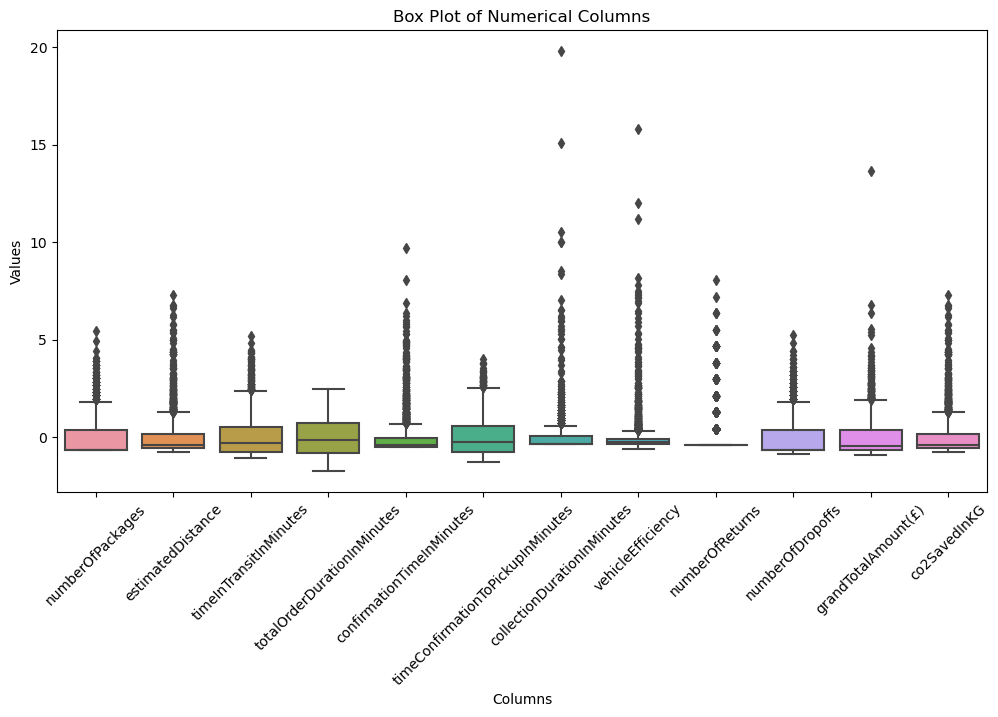

In [5]:
# Select the numerical columns
numerical_columns = ['numberOfPackages', 'estimatedDistance', 'timeInTransitInMinutes', 
                     'totalOrderDurationInMinutes', 'confirmationTimeInMinutes', 
                     'timeConfirmationToPickupInMinutes', 'collectionDurationInMinutes', 
                     'vehicleEfficiency', 'numberOfReturns', 'numberOfDropoffs', 'grandTotalAmount(£)','co2SavedInKG'
                     ]

# Create a box plot for each numerical column
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numerical_columns])
plt.xticks(rotation=45)
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Box Plot of Numerical Columns')
plt.show()

In [6]:
# Select the numerical columns
numerical_columns = ['numberOfPackages', 'estimatedDistance', 'timeInTransitInMinutes', 
                     'totalOrderDurationInMinutes', 'confirmationTimeInMinutes', 
                     'timeConfirmationToPickupInMinutes', 'collectionDurationInMinutes', 
                     'vehicleEfficiency', 'numberOfReturns', 'numberOfDropoffs', 'grandTotalAmount(£)','co2SavedInKG'
                    ]

# Calculate the z-scores for each numerical column
z_scores = stats.zscore(df[numerical_columns])

# Set a threshold for outlier detection
threshold = 3

# Find the number of outliers per variable
outlier_counts = (z_scores > threshold).sum(axis=0)

# Print the number of outliers per variable
for column, count in zip(numerical_columns, outlier_counts):
    print(f"Number of outliers in {column}: {count}")

Number of outliers in numberOfPackages: 43
Number of outliers in estimatedDistance: 51
Number of outliers in timeInTransitInMinutes: 40
Number of outliers in totalOrderDurationInMinutes: 0
Number of outliers in confirmationTimeInMinutes: 63
Number of outliers in timeConfirmationToPickupInMinutes: 20
Number of outliers in collectionDurationInMinutes: 28
Number of outliers in vehicleEfficiency: 44
Number of outliers in numberOfReturns: 44
Number of outliers in numberOfDropoffs: 31
Number of outliers in grandTotalAmount(£): 37
Number of outliers in co2SavedInKG: 51


In [7]:
# Remove the outliers from the DataFrame
outlier_indices = (z_scores > threshold).any(axis=1)
df = df[~outlier_indices]

In [8]:
df.shape

(1911, 24)

## Encoding Categorical Variables<a class="anchor" id="Encoding"></a>

Based on the data above, all the categorical can be encoded for the predictive models. These variables represent different categories or labels rather than numerical values. Encoding them will allow the models to process and interpret the categorical information effectively.

**isExpressDelivery and isMultidropCourierOrder**

As these two variables only have 0 or 1 values, they already are binary variables, with values of 0 and 1 indicating 'no' and 'yes', respectively.

In [9]:
# count the number of values
count = df['isExpressDelivery'].value_counts()
count2 = df['isMultidropCourierOrder'].value_counts()

print("isExpressDelivery:\n", count)
print("isMultidropCourierOrder:\n", count2)

isExpressDelivery:
 0.0    1841
1.0      70
Name: isExpressDelivery, dtype: int64
isMultidropCourierOrder:
 0    1077
1     834
Name: isMultidropCourierOrder, dtype: int64


In [10]:
# Convert the isExpressDelivery column to numeric format
df['isExpressDelivery'] = pd.to_numeric(df['isExpressDelivery'], errors='coerce')

# Convert the isExpressDelivery column to integer type
df['isExpressDelivery'] = df['isExpressDelivery'].astype(int)

In [11]:
df.head()

,orderID,businessType,business_vs_Customer,numberOfPackages,estimatedDistance,timeInTransitInMinutes,totalOrderDurationInMinutes,confirmationTimeInMinutes,timeConfirmationToPickupInMinutes,collectionDurationInMinutes,...,numberOfDropoffs,grandTotalAmount(£),co2SavedInKG,volume_category,Region,year,month,day,timeOfDay,Season
1,1629,Pharmacy,business,-0.658007,-0.441662,-0.809594,-1.099583,-0.400520,-0.615017,-0.354842,...,-0.664186,-0.533208,-0.441715,Small,Kensington and Chelsea,2021,11,2,Afternoon,Autumn
2,1630,Pharmacy,business,-0.658007,-0.341695,-0.430161,-0.534299,-0.454031,-0.852612,-0.354842,...,-0.664186,-0.609817,-0.341933,Small,Hammersmith and Fulham,2021,11,2,Afternoon,Autumn
3,1631,Pharmacy,business,-0.658007,-0.441662,-0.749684,-1.182020,0.027570,-0.900131,-0.354842,...,-0.664186,-0.533208,-0.441715,Small,Kensington and Chelsea,2021,11,2,Afternoon,Autumn
4,1632,Pharmacy,business,-0.658007,-0.541629,-0.530012,-1.028922,-0.507543,-1.011008,-0.354842,...,-0.664186,-0.700658,-0.541498,Small,Kensington and Chelsea,2021,11,2,Afternoon,Autumn
5,1633,Pharmacy,business,-0.658007,-0.597166,-0.949385,0.478502,-0.454031,1.650047,-0.354842,...,-0.664186,-0.664321,-0.596986,Medium,Lambeth,2021,11,3,Morning,Autumn


**Region, business_vs_Customer, volume_category, businessType, Season and timeOfDay** 

In this step, we perform one-hot encoding on the categorical variables to convert them into a format suitable for the predictive models. One-hot encoding is used for categorical variables that have multiple categories or labels. It creates binary columns for each category, where a value of 1 indicates the presence of that category, and 0 indicates absence.

In [12]:
# Perform one-hot encoding on the columns
encoded_regions = pd.get_dummies(df['Region'], prefix='Region')
encoded_business_type = pd.get_dummies(df['businessType'], prefix='businessType')
encoded_business_vs_customer = pd.get_dummies(df['business_vs_Customer'], prefix='business_vs_Customer')
encoded_volume_category = pd.get_dummies(df['volume_category'], prefix='volume_category')
encoded_seasons = pd.get_dummies(df['Season'], prefix='Season')
encoded_timeofday = pd.get_dummies(df['timeOfDay'], prefix='timeOfDay')

# Concatenate the encoded back to the original DataFrame
df = pd.concat([df, encoded_regions], axis=1)
df = pd.concat([df, encoded_business_type], axis=1)
df = pd.concat([df, encoded_business_vs_customer], axis=1)
df = pd.concat([df, encoded_volume_category], axis=1)
df = pd.concat([df, encoded_seasons], axis=1)
df = pd.concat([df, encoded_timeofday], axis=1)


# Remove the original columns
df.drop('Region', axis=1, inplace=True)
df.drop('businessType', axis=1, inplace=True)
df.drop('business_vs_Customer', axis=1, inplace=True)
df.drop('volume_category', axis=1, inplace=True)
df.drop('Season', axis=1, inplace=True)
df.drop('timeOfDay', axis=1, inplace=True)

In [13]:
df.head()

,orderID,numberOfPackages,estimatedDistance,timeInTransitInMinutes,totalOrderDurationInMinutes,confirmationTimeInMinutes,timeConfirmationToPickupInMinutes,collectionDurationInMinutes,vehicleEfficiency,isExpressDelivery,...,volume_category_Medium,volume_category_Other,volume_category_Small,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,timeOfDay_Afternoon,timeOfDay_Evening,timeOfDay_Morning
1,1629,-0.658007,-0.441662,-0.809594,-1.099583,-0.400520,-0.615017,-0.354842,-0.396045,1,...,0,0,1,1,0,0,0,1,0,0
2,1630,-0.658007,-0.341695,-0.430161,-0.534299,-0.454031,-0.852612,-0.354842,0.634115,0,...,0,0,1,1,0,0,0,1,0,0
3,1631,-0.658007,-0.441662,-0.749684,-1.182020,0.027570,-0.900131,-0.354842,-0.346990,1,...,0,0,1,1,0,0,0,1,0,0
4,1632,-0.658007,-0.541629,-0.530012,-1.028922,-0.507543,-1.011008,-0.354842,0.143564,0,...,0,0,1,1,0,0,0,1,0,0
5,1633,-0.658007,-0.597166,-0.949385,0.478502,-0.454031,1.650047,-0.354842,-0.460194,0,...,1,0,0,1,0,0,0,0,0,1


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1911 entries, 1 to 2200
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   orderID                            1911 non-null   int64  
 1   numberOfPackages                   1911 non-null   float64
 2   estimatedDistance                  1911 non-null   float64
 3   timeInTransitInMinutes             1911 non-null   float64
 4   totalOrderDurationInMinutes        1911 non-null   float64
 5   confirmationTimeInMinutes          1911 non-null   float64
 6   timeConfirmationToPickupInMinutes  1911 non-null   float64
 7   collectionDurationInMinutes        1911 non-null   float64
 8   vehicleEfficiency                  1911 non-null   float64
 9   isExpressDelivery                  1911 non-null   int64  
 10  isMultidropCourierOrder            1911 non-null   int64  
 11  numberOfReturns                    1911 non-null   float

## Data Splitting<a class="anchor" id="Splitting"></a>

In this step, we split the data into training and testing sets. The training set is used to train the predictive models, while the testing set is used to evaluate the model's performance on unseen data.

The features (X) and the target variable (y) are separated from the DataFrame. The target variable is 'totalOrderDurationInMinutes,' which we aim to predict. The features are all the other columns in the DataFrame, excluding 'totalOrderDurationInMinutes.'

We use the train_test_split() function from Scikit-learn to split the data into training and testing sets. The test_size parameter is set to 0.2, meaning 20% of the data will be used for testing, and the rest (80%) will be used for training. The random_state parameter is set to 42 to ensure reproducibility.

Finally, we display the shapes of the training and testing datasets to confirm that the split has been done correctly. The training dataset has 1528 samples, while the testing dataset has 383 samples. Each dataset has 43 columns, consisting of the encoded features.

In [15]:
# Separate the features (X) and the target variable (y)
X = df.drop('totalOrderDurationInMinutes', axis=1)
y = df['totalOrderDurationInMinutes']

# Split the data into training and testing sets while preserving class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training Datasets:'),print(y_train.shape, X_train.shape)
print('-'*20)
print('Testing Datasets:'),print(y_test.shape, X_test.shape)

Training Datasets:
(1528,) (1528, 43)
--------------------
Testing Datasets:
(383,) (383, 43)


(None, None)

# 3. Linear Regression<a class="anchor" id="Linear"></a>

**Initial Model Building**

In [16]:
# Initialize the initial linear regression model
initial_lr_model = LinearRegression()

# Perform cross-validation for initial evaluation on the training data
initial_lr_scores = cross_validate(initial_lr_model, X_train, y_train, cv=10,
                                   scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'])
initial_lr_r2 = np.mean(initial_lr_scores['test_r2'])
initial_lr_mse = -np.mean(initial_lr_scores['test_neg_mean_squared_error'])
initial_lr_mae = -np.mean(initial_lr_scores['test_neg_mean_absolute_error'])

print("Initial Linear Regression Model Evaluation on Training Data:")
print("R-squared:", initial_lr_r2)
print("Mean Squared Error:", initial_lr_mse)
print("Mean Absolute Error:", initial_lr_mae)

Initial Linear Regression Model Evaluation on Training Data:
R-squared: 0.9647849973648555
Mean Squared Error: 0.029673717941094635
Mean Absolute Error: 0.09680970493849936


**Addressing Multicollinearity**

Addressing multicollinearity, or the presence of high correlation among predictor variables, is crucial in regression analysis to ensure model validity and interpretability as it can affect the independence assumption. In addition to correlation analysis, Variance Inflation Factor (VIF) and Tolerance were used to better understand the multicollinearity in the data. A commonly used rule is that VIFs exceeding 4 should be further examined, whilst values above 10 indicate severe multicollinearity. Therefore, applying the commonly used thresholds of VIF < 10 and Tolerance > 0.1, the highly correlated variables numberOfDropoffs and co2SavedInKG were identified and removed. After doing so, the remaining variables exhibit reduced VIF and tolerance values, indicating a significant reduction in multicollinearity, ensuring the model's reliability and stability.

In [17]:
# Select the numerical variables of interest for multicollinearity analysis
variables_of_interest = ['numberOfPackages', 'estimatedDistance', 'timeInTransitInMinutes',
                         'confirmationTimeInMinutes', 'timeConfirmationToPickupInMinutes',
                         'collectionDurationInMinutes', 'vehicleEfficiency', 'numberOfReturns', 
                         'numberOfDropoffs','grandTotalAmount(£)', 'year', 'month', 'day', 'co2SavedInKG']

# Create an empty DataFrame to store the results
vif_data = pd.DataFrame(columns=['Variable', 'VIF_Train', 'Tolerance_Train', 'VIF_Test', 'Tolerance_Test'])

# Calculate VIF and Tolerance for train data
numerical_variables_train = X_train[variables_of_interest]
vif_train = [variance_inflation_factor(numerical_variables_train.values, i) for i in range(numerical_variables_train.shape[1])]
tol_train = [1 / vif for vif in vif_train]

# Calculate VIF and Tolerance for test data
numerical_variables_test = X_test[variables_of_interest]
vif_test = [variance_inflation_factor(numerical_variables_test.values, i) for i in range(numerical_variables_test.shape[1])]
tol_test = [1 / vif for vif in vif_test]

# Add the results to the DataFrame
vif_data['Variable'] = variables_of_interest
vif_data['VIF_Train'] = vif_train
vif_data['Tolerance_Train'] = tol_train
vif_data['VIF_Test'] = vif_test
vif_data['Tolerance_Test'] = tol_test

# Format VIF and Tolerance values
vif_data['VIF_Train'] = vif_data['VIF_Train'].apply(lambda x: format(x, '.2f'))
vif_data['Tolerance_Train'] = vif_data['Tolerance_Train'].apply(lambda x: format(x, '.2f'))
vif_data['VIF_Test'] = vif_data['VIF_Test'].apply(lambda x: format(x, '.2f'))
vif_data['Tolerance_Test'] = vif_data['Tolerance_Test'].apply(lambda x: format(x, '.2f'))

# Rearrange the DataFrame columns
vif_data = vif_data[['Variable', 'VIF_Train', 'VIF_Test', 'Tolerance_Train', 'Tolerance_Test']]

# Print the results
print(vif_data)

                             Variable    VIF_Train     VIF_Test  \
0                    numberOfPackages      7598.95      2085.79   
1                   estimatedDistance  25770201.27  24947955.93   
2              timeInTransitInMinutes         4.15         4.35   
3           confirmationTimeInMinutes         1.07         1.11   
4   timeConfirmationToPickupInMinutes         1.06         1.05   
5         collectionDurationInMinutes         2.00         2.35   
6                   vehicleEfficiency         1.72         1.62   
7                     numberOfReturns       221.93        63.37   
8                    numberOfDropoffs      5910.64      1618.80   
9                 grandTotalAmount(£)         6.36         5.91   
10                               year         7.56         7.72   
11                              month         3.71         3.83   
12                                day         4.18         4.28   
13                       co2SavedInKG  25770777.27  24948542.3

In [18]:
X_train_lr = X_train.drop(columns=['numberOfDropoffs']) # Remove highly correlated variable
X_test_lr = X_test.drop(columns=['numberOfDropoffs']) # Remove highly correlated variable

X_train_lr = X_train.drop(columns=['co2SavedInKG']) # Remove highly correlated variable
X_test_lr = X_test.drop(columns=['co2SavedInKG']) # Remove highly correlated variable

CO2SavedInKG is very highly correlated with estimatedDistance, because CO2SavedInKG is a direct function of estimatedDistance. Therefore, it is better to drop this variable from all data for all our predictive models. 

In [19]:
X_train = X_train.drop(columns=['co2SavedInKG'])
X_test = X_test.drop(columns=['co2SavedInKG'])

In [20]:
# Select the numerical variables of interest for multicollinearity analysis
variables_of_interest = ['numberOfPackages', 'estimatedDistance', 'timeInTransitInMinutes',
                         'confirmationTimeInMinutes', 'timeConfirmationToPickupInMinutes',
                         'collectionDurationInMinutes', 'vehicleEfficiency', 'numberOfReturns', 'grandTotalAmount(£)',
                         'month', 'day','year']

# Create an empty DataFrame to store the results
vif_data = pd.DataFrame(columns=['Variable', 'VIF_Train', 'Tolerance_Train', 'VIF_Test', 'Tolerance_Test'])

# Calculate VIF and Tolerance for train data
numerical_variables_train = X_train_lr[variables_of_interest]
vif_train = [variance_inflation_factor(numerical_variables_train.values, i) for i in range(numerical_variables_train.shape[1])]
tol_train = [1 / vif for vif in vif_train]

# Calculate VIF and Tolerance for test data
numerical_variables_test = X_test_lr[variables_of_interest]
vif_test = [variance_inflation_factor(numerical_variables_test.values, i) for i in range(numerical_variables_test.shape[1])]
tol_test = [1 / vif for vif in vif_test]

# Add the results to the DataFrame
vif_data['Variable'] = variables_of_interest
vif_data['VIF_Train'] = vif_train
vif_data['Tolerance_Train'] = tol_train
vif_data['VIF_Test'] = vif_test
vif_data['Tolerance_Test'] = tol_test

# Format VIF and Tolerance values
vif_data['VIF_Train'] = vif_data['VIF_Train'].apply(lambda x: format(x, '.2f'))
vif_data['Tolerance_Train'] = vif_data['Tolerance_Train'].apply(lambda x: format(x, '.2f'))
vif_data['VIF_Test'] = vif_data['VIF_Test'].apply(lambda x: format(x, '.2f'))
vif_data['Tolerance_Test'] = vif_data['Tolerance_Test'].apply(lambda x: format(x, '.2f'))

# Rearrange the DataFrame columns
vif_data = vif_data[['Variable', 'VIF_Train', 'VIF_Test', 'Tolerance_Train', 'Tolerance_Test']]

# Print the results
print(vif_data)

                             Variable VIF_Train VIF_Test Tolerance_Train  \
0                    numberOfPackages      4.94     5.17            0.20   
1                   estimatedDistance      4.24     4.36            0.24   
2              timeInTransitInMinutes      4.15     4.33            0.24   
3           confirmationTimeInMinutes      1.07     1.11            0.94   
4   timeConfirmationToPickupInMinutes      1.05     1.04            0.95   
5         collectionDurationInMinutes      1.97     2.27            0.51   
6                   vehicleEfficiency      1.71     1.61            0.58   
7                     numberOfReturns      2.18     2.01            0.46   
8                 grandTotalAmount(£)      6.09     5.77            0.16   
9                               month      3.70     3.81            0.27   
10                                day      4.17     4.26            0.24   
11                               year      7.53     7.71            0.13   

   Toleranc

In [21]:
X_train_lr.columns

Index(['orderID', 'numberOfPackages', 'estimatedDistance',
       'timeInTransitInMinutes', 'confirmationTimeInMinutes',
       'timeConfirmationToPickupInMinutes', 'collectionDurationInMinutes',
       'vehicleEfficiency', 'isExpressDelivery', 'isMultidropCourierOrder',
       'numberOfReturns', 'numberOfDropoffs', 'grandTotalAmount(£)', 'year',
       'month', 'day', 'Region_Hammersmith and Fulham', 'Region_Islington',
       'Region_Kensington and Chelsea', 'Region_Lambeth', 'Region_Merton',
       'Region_Southwark', 'Region_Wandsworth', 'Region_Westminster',
       'businessType_Florist', 'businessType_Grocery store',
       'businessType_Other', 'businessType_Pharmacy', 'businessType_Retailer',
       'business_vs_Customer_business', 'business_vs_Customer_customer',
       'business_vs_Customer_other', 'volume_category_Medium',
       'volume_category_Other', 'volume_category_Small', 'Season_Autumn',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'timeOfDay_Afte

**Normalisation of Data Distribution**

Normalising data distributions is necessary as they may violate the normality assumption of residuals and lead to biased results. While analysing the dataset, the skewness of the independent variables (X) and the dependent variable (y) were examined, as both may affect the normality assumption. Based on the skewness results, the highly skewed variables include numberOfPackages, estimatedDistance, timeInTransitInMinutes, confirmationTimeInMinutes, collectionDurationInMinutes, vehicleEfficiency, numberOfReturns, and grandTotalAmount(£). These variables exhibited skewness values greater than one or less than -1, indicating a significant departure from a normal distribution. A square root transformation with a constant was applied to normalise the distribution and reduce the impact of extreme values. This helps improve the interpretation of coefficients and enhances the model's predictive performance.

In [22]:
# Select the numerical variables of interest
variables_of_interest = ['numberOfPackages', 'estimatedDistance', 'timeInTransitInMinutes',
                       'confirmationTimeInMinutes', 'timeConfirmationToPickupInMinutes',
                       'collectionDurationInMinutes', 'vehicleEfficiency', 'numberOfReturns',
                       'grandTotalAmount(£)']

# Get the list of all variables
all_variables = X_train_lr.columns.tolist()

# Get the list of categorical variables
other_variables = [var for var in all_variables if var not in variables_of_interest]

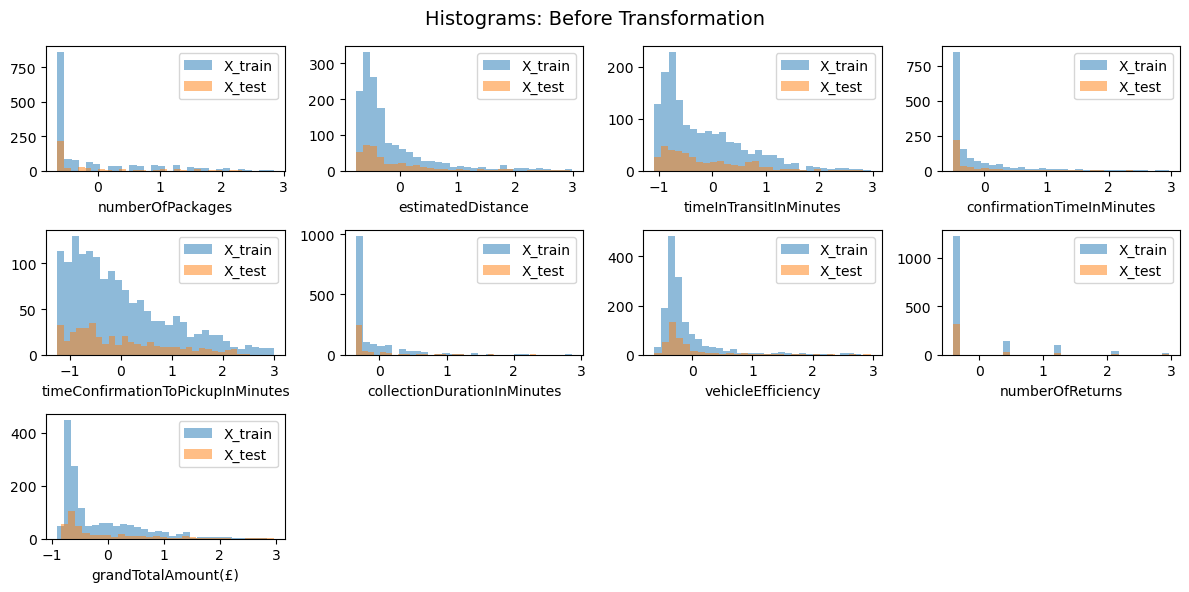

In [23]:
# Plot histograms before transformation
plt.figure(figsize=(12, 6))
plt.suptitle('Histograms: Before Transformation', fontsize=14)

for i, var in enumerate(variables_of_interest):
    plt.subplot(3, 4, i+1)
    plt.hist(X_train[var], bins=30, alpha=0.5, label='X_train')
    plt.hist(X_test[var], bins=30, alpha=0.5, label='X_test')
    plt.xlabel(var)
    plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Calculate skewness for X_train
skewness_X_train_before = X_train_lr[variables_of_interest].apply(skew)

# Calculate skewness for X_test
skewness_X_test_before = X_test_lr[variables_of_interest].apply(skew)

# Create a dataframe to store the skewness results before transformation
skewness_df_before = pd.DataFrame({
    'Variable': variables_of_interest,
    'Skewness_X_train_before': skewness_X_train_before.values,
    'Skewness_X_test_before': skewness_X_test_before.values,
})

# Print the skewness results before transformation
print("Before transformation:")
print(skewness_df_before)

Before transformation:
                            Variable  Skewness_X_train_before  \
0                   numberOfPackages                 1.550571   
1                  estimatedDistance                 2.170532   
2             timeInTransitInMinutes                 1.177919   
3          confirmationTimeInMinutes                 2.540844   
4  timeConfirmationToPickupInMinutes                 0.927608   
5        collectionDurationInMinutes                 2.908056   
6                  vehicleEfficiency                 2.946501   
7                    numberOfReturns                 2.551797   
8                grandTotalAmount(£)                 1.522733   

   Skewness_X_test_before  
0                1.430923  
1                2.068632  
2                1.155013  
3                2.345756  
4                0.804207  
5                2.725492  
6                3.121252  
7                2.787230  
8                1.546439  


In [25]:
# Select the skewed variables
skewed_variables = skewness_X_train_before[(skewness_X_train_before > 1) | (skewness_X_train_before < -1)].index.tolist()
skewed_variables

['numberOfPackages',
 'estimatedDistance',
 'timeInTransitInMinutes',
 'confirmationTimeInMinutes',
 'collectionDurationInMinutes',
 'vehicleEfficiency',
 'numberOfReturns',
 'grandTotalAmount(£)']

In [26]:
# Calculate the shift constant based on the minimum value across all numerical variables
shift_constant = np.abs(X_train_lr[variables_of_interest].values.min())
shift_constant = np.ceil(shift_constant)
shift_constant

2.0

In [27]:
# Apply shift constant to X_train and X_test
X_train_shifted = X_train_lr[variables_of_interest] + shift_constant
X_test_shifted = X_test_lr[variables_of_interest] + shift_constant

# Apply Square Root transformation to skewed variables in X_train_shifted and X_test_shifted
X_train_transformed = X_train_shifted.copy()
X_test_transformed = X_test_shifted.copy()

for var in skewed_variables:
    X_train_transformed[var] = np.sqrt(X_train_shifted[var])
    X_test_transformed[var] = np.sqrt(X_test_shifted[var])

# Concatenate the transformed numerical variables with the original categorical variables in X_train and X_test
X_train_transformed = pd.concat([X_train_transformed, X_train_lr[other_variables]], axis=1)
X_test_transformed = pd.concat([X_test_transformed, X_test_lr[other_variables]], axis=1)

**Cross Validation**

In [28]:
# Initialize the linear regression model
final_lr_model = LinearRegression()

# Perform cross-validation on the training data using the best model
final_train_lr_scores = cross_validate(final_lr_model, X_train_transformed, y_train, cv=10,
                                       scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'])
final_train_lr_r2 = np.mean(final_train_lr_scores['test_r2'])
final_train_lr_mse = -np.mean(final_train_lr_scores['test_neg_mean_squared_error'])
final_train_lr_mae = -np.mean(final_train_lr_scores['test_neg_mean_absolute_error'])

print("\nFinal Linear Regression Model Evaluation on Training Data:")
print("R-squared:", final_train_lr_r2)
print("Mean Squared Error:", final_train_lr_mse)
print("Mean Absolute Error:", final_train_lr_mae)


Final Linear Regression Model Evaluation on Training Data:
R-squared: 0.962952266204112
Mean Squared Error: 0.031220884588248753
Mean Absolute Error: 0.10634567705929934


**Evaluation on Test Set**

In [29]:
# Fit the model to the entire training data
final_lr_model.fit(X_train_transformed, y_train)

# Make predictions on the test set
y_pred_test = final_lr_model.predict(X_test_transformed)

# Calculate evaluation metrics on the test set
final_lr_r2 = r2_score(y_test, y_pred_test)
final_lr_mse = mean_squared_error(y_test, y_pred_test)
final_lr_mae = mean_absolute_error(y_test, y_pred_test)

# Print the evaluation metrics
print("Final Linear Regression Model Evaluation on Test Set:")
print("R-squared:", final_lr_r2)
print("Mean Squared Error:", final_lr_mse)
print("Mean Absolute Error:", final_lr_mae)

Final Linear Regression Model Evaluation on Test Set:
R-squared: 0.9682010627336235
Mean Squared Error: 0.025052237716005867
Mean Absolute Error: 0.10464450563840455


### Comparison Initial Linear Regression vs Final Linear Regression Model

In [30]:
# Initial model results
print("Initial Linear Regression Model Evaluation on Training Data:")
print("R-squared:", round(initial_lr_r2, 3))
print("Mean Squared Error:", round(initial_lr_mse, 3))
print("Mean Absolute Error:", round(initial_lr_mae, 3))

# Final model results
print("\nFinal Linear Regression Model Evaluation on Training Data:")
print("R-squared:", round(final_lr_r2, 3))
print("Mean Squared Error:", round(final_lr_mse, 3))
print("Mean Absolute Error:", round(final_lr_mae, 3))

Initial Linear Regression Model Evaluation on Training Data:
R-squared: 0.965
Mean Squared Error: 0.03
Mean Absolute Error: 0.097

Final Linear Regression Model Evaluation on Training Data:
R-squared: 0.968
Mean Squared Error: 0.025
Mean Absolute Error: 0.105


### Linear Regression Assumptions Check

After building the linear regression model, it is important to check again whether the assumptions of the linear regression were upheld to ensure the validity and reliability of the results. 

In [31]:
residuals = y_test - y_pred_test
sqrt_abs_res = np.sqrt(np.abs(residuals))

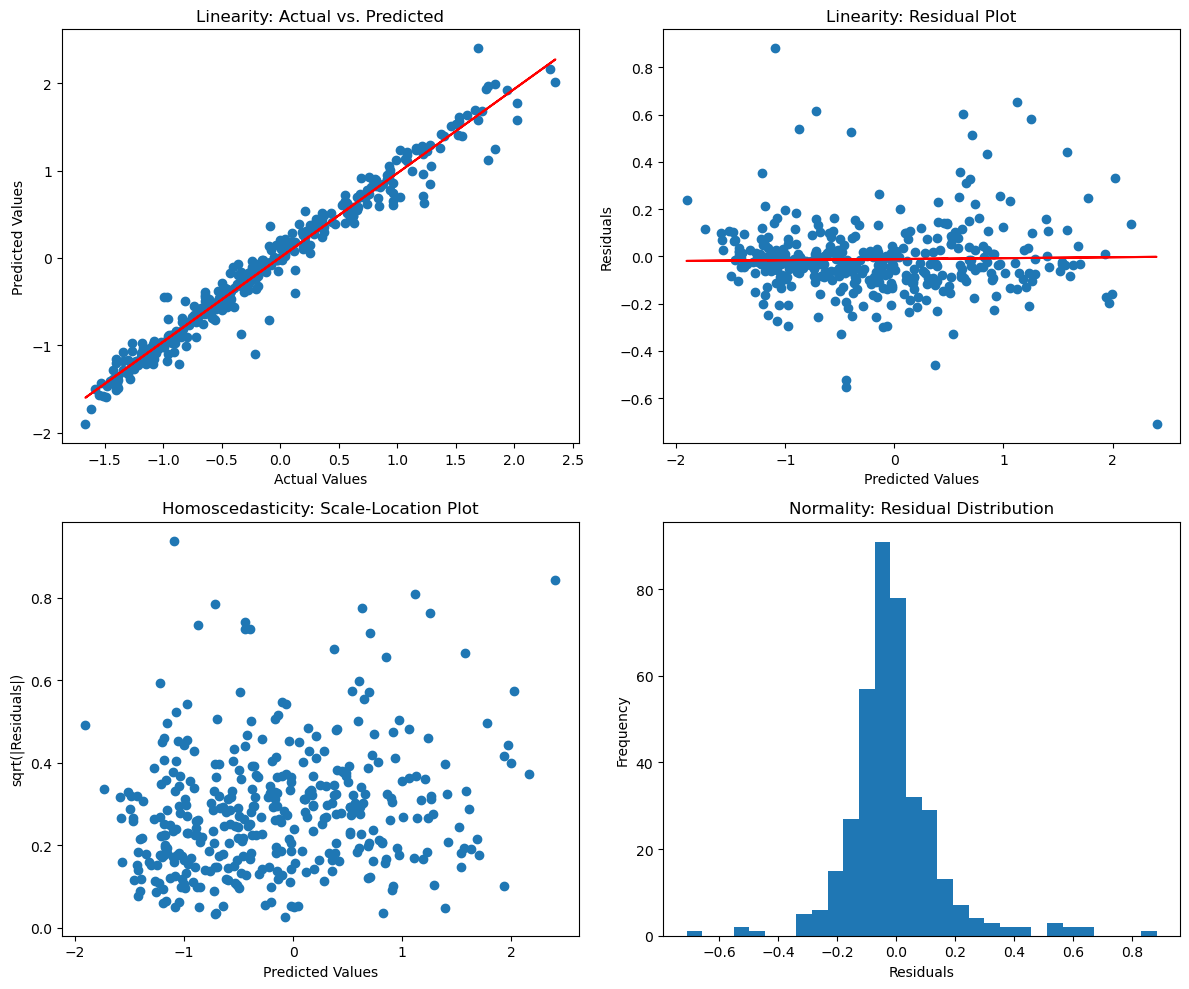

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Scatter plot
axes[0, 0].scatter(y_test, y_pred_test)
axes[0, 0].set_xlabel('Actual Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title('Linearity: Actual vs. Predicted')

# Add trendline
trendline = np.polyfit(y_test, y_pred_test, 1)
axes[0, 0].plot(y_test, trendline[0] * y_test + trendline[1], color='red')

# Residual plot
axes[0, 1].scatter(y_pred_test, residuals)
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Linearity: Residual Plot')

# Add trendline
trendline = np.polyfit(y_pred_test, residuals, 1)
axes[0, 1].plot(y_pred_test, trendline[0] * y_pred_test + trendline[1], color='red')

# Scale-Location Plot
axes[1, 0].scatter(y_pred_test, sqrt_abs_res)
axes[1, 0].set_xlabel('Predicted Values')
axes[1, 0].set_ylabel('sqrt(|Residuals|)')
axes[1, 0].set_title('Homoscedasticity: Scale-Location Plot')

# Histogram
axes[1, 1].hist(residuals, bins=30)
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Normality: Residual Distribution')

plt.tight_layout()
plt.show()

**Independence**

In [33]:
# Durbin-Watson test
durbin_watson_stat = durbin_watson(residuals)
print("Independence: Durbin-Watson Statistic:", durbin_watson_stat)

Independence: Durbin-Watson Statistic: 1.9573346688412565


# 4. Regression Tree<a class="anchor" id="RegressionTree"></a>

**Initial Model Building**

The Regression Tree model was used for this study due to the quantitative nature of the dependent variable. An initial tree was built and evaluated on the training data using cross-validation. cross_validate function is used to perform k-fold cross-validation (here, k=10) on the training data. It evaluates the model's performance using three metrics: R-squared, negative mean squared error (MSE), and negative mean absolute error (MAE).

In [34]:
# Initialize the initial decision tree model
initial_dt_model = DecisionTreeRegressor()

# Perform cross-validation for initial evaluation on the training data
initial_dt_scores = cross_validate(initial_dt_model, X_train, y_train, cv=10,
                                   scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'])
initial_dt_r2 = np.mean(initial_dt_scores['test_r2'])
initial_dt_mse = -np.mean(initial_dt_scores['test_neg_mean_squared_error'])
initial_dt_mae = -np.mean(initial_dt_scores['test_neg_mean_absolute_error'])

print("Initial Decision Tree Model Evaluation on Training Data:")
print("R-squared:", initial_dt_r2)
print("Mean Squared Error:", initial_dt_mse)
print("Mean Absolute Error:", initial_dt_mae)

Initial Decision Tree Model Evaluation on Training Data:
R-squared: 0.9037210050442048
Mean Squared Error: 0.08012714489143367
Mean Absolute Error: 0.16989696261273207


**Hyperparameter Tuning with Cross Validation**

Different hyperparameters (max_depth, min_samples_split, min_samples_leaf, ccp_alpha) of the decision tree are specified with different values to be searched over. GridSearchCV is used to perform a grid search over the hyperparameter space. It tries different combinations of hyperparameters and evaluates the model using cross-validation. The best hyperparameters and model obtained from the grid search are then stored.

In [35]:
# Define the hyperparameters to tune
param_grid = {
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'ccp_alpha': [0.0, 0.01, 0.1, 0.5, 1.0]  # Cost complexity pruning alpha values
}

# Initialize the decision tree model
dt_model = DecisionTreeRegressor()

# Perform grid search cross-validation
grid_search = GridSearchCV(dt_model, param_grid, cv=10, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_dt_params = grid_search.best_params_
best_dt_model = grid_search.best_estimator_

# Print the best hyperparameters
print("\nBest Decision Tree Hyperparameters:")
print(best_dt_params)


Best Decision Tree Hyperparameters:
{'ccp_alpha': 0.0, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}


**Cross Validation**

In [36]:
# Perform cross-validation on the training data using the best model
final_train_dt_scores = cross_validate(best_dt_model, X_train, y_train, cv=10,
                                       scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'])
final_train_dt_r2 = np.mean(final_train_dt_scores['test_r2'])
final_train_dt_mse = -np.mean(final_train_dt_scores['test_neg_mean_squared_error'])
final_train_dt_mae = -np.mean(final_train_dt_scores['test_neg_mean_absolute_error'])

print("\nFinal Decision Tree Model Evaluation on Training Data:")
print("R-squared:", final_train_dt_r2)
print("Mean Squared Error:", final_train_dt_mse)
print("Mean Absolute Error:", final_train_dt_mae)


Final Decision Tree Model Evaluation on Training Data:
R-squared: 0.9161296719283685
Mean Squared Error: 0.06988288710095414
Mean Absolute Error: 0.1647220938270659


**Evaluation on Test Set**

Final Decision Tree Model Evaluation on Test Set:
R-squared: 0.9480241088855865
Mean Squared Error: 0.04094829864255707
Mean Absolute Error: 0.13840519008727248


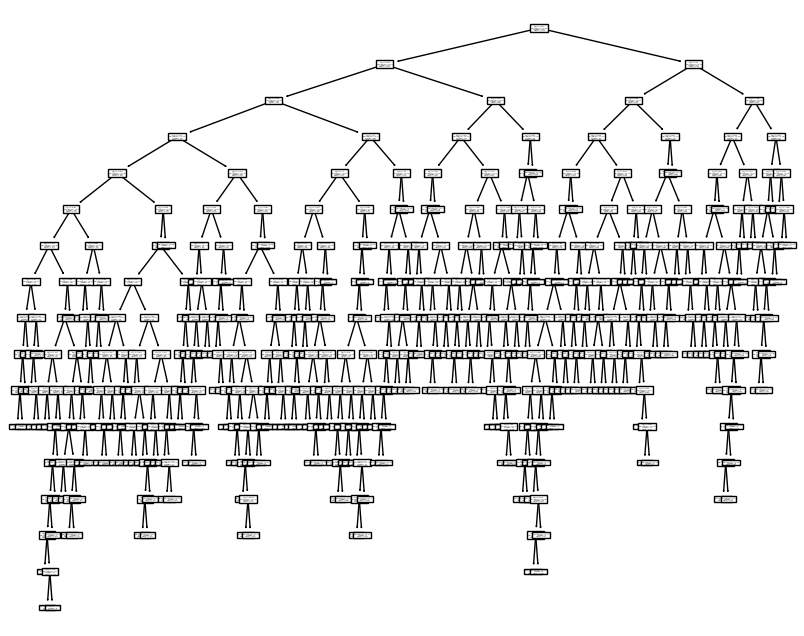

In [37]:
# Prune the decision tree using the optimal pruning level (ccp_alpha)
pruned_dt_model = DecisionTreeRegressor(**best_dt_params)
pruned_dt_model.fit(X_train, y_train)

# Evaluate the pruned model on the test set
y_pred_test = pruned_dt_model.predict(X_test)
final_dt_r2 = r2_score(y_test, y_pred_test)
final_dt_mse = mean_squared_error(y_test, y_pred_test)
final_dt_mae = mean_absolute_error(y_test, y_pred_test)

print("Final Decision Tree Model Evaluation on Test Set:")
print("R-squared:", final_dt_r2)
print("Mean Squared Error:", final_dt_mse)
print("Mean Absolute Error:", final_dt_mae)

# Plot the decision tree
plt.figure(figsize=(10, 8))
tree.plot_tree(pruned_dt_model)
plt.show()

# 5. Random Forest<a class="anchor" id="RandomForest"></a>

**Initial Model**

In [38]:
# Initialize the initial random forest model
initial_rf_model = RandomForestRegressor()

# Perform cross-validation for initial evaluation on the training data
initial_rf_scores = cross_validate(initial_rf_model, X_train, y_train, cv=10,
                                   scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'])
initial_rf_r2 = np.mean(initial_rf_scores['test_r2'])
initial_rf_mse = -np.mean(initial_rf_scores['test_neg_mean_squared_error'])
initial_rf_mae = -np.mean(initial_rf_scores['test_neg_mean_absolute_error'])

print("Initial Random Forest Model Evaluation on Training Data:")
print("R-squared:", initial_rf_r2)
print("Mean Squared Error:", initial_rf_mse)
print("Mean Absolute Error:", initial_rf_mae)

Initial Random Forest Model Evaluation on Training Data:
R-squared: 0.9540608658496399
Mean Squared Error: 0.038458620372398875
Mean Absolute Error: 0.11336496238841165


**Hyperparameter Tuning with Cross Validation**

In [39]:
# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 4, 7]
}

# Initialize the random forest model
rf_model = RandomForestRegressor()

# Perform grid search cross-validation
tree_random_search = RandomizedSearchCV(rf_model, param_grid, cv=10, scoring='r2', n_iter = 100)
tree_random_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_rf_params = tree_random_search.best_params_
best_rf_model = tree_random_search.best_estimator_

# Print the best hyperparameters
print("\nBest Random Forest Hyperparameters:")
print(best_rf_params)


Best Random Forest Hyperparameters:
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}


**Cross Validation**

In [40]:
# Perform cross-validation on the training data using the best model
final_train_rf_scores = cross_validate(best_rf_model, X_train, y_train, cv=10,
                                       scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'])
final_train_rf_r2 = np.mean(final_train_rf_scores['test_r2'])
final_train_rf_mse = -np.mean(final_train_rf_scores['test_neg_mean_squared_error'])
final_train_rf_mae = -np.mean(final_train_rf_scores['test_neg_mean_absolute_error'])

print("\nFinal Random Forest Model Evaluation on Training Data:")
print("R-squared:", final_train_rf_r2)
print("Mean Squared Error:", final_train_rf_mse)
print("Mean Absolute Error:", final_train_rf_mae)


Final Random Forest Model Evaluation on Training Data:
R-squared: 0.9546280222316978
Mean Squared Error: 0.038006329627426214
Mean Absolute Error: 0.11250611775174128


**Evaluation on Test Set**

In [41]:
# Initialize the Random Forest model with the best hyperparameters
final_rf_model = RandomForestRegressor(**best_rf_params)

# Fit the model to the entire training data
final_rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = final_rf_model.predict(X_test)

# Calculate evaluation metrics on the test set
final_rf_r2 = r2_score(y_test, y_pred_test)
final_rf_mse = mean_squared_error(y_test, y_pred_test)
final_rf_mae = mean_absolute_error(y_test, y_pred_test)

# Print the evaluation metrics
print("Final Random Forest Model Evaluation on Test Set:")
print("R-squared:", final_rf_r2)
print("Mean Squared Error:", final_rf_mse)
print("Mean Absolute Error:", final_rf_mae)

Final Random Forest Model Evaluation on Test Set:
R-squared: 0.9666123034479314
Mean Squared Error: 0.02630391398950061
Mean Absolute Error: 0.10096556727635513


# 6. AdaBoost<a class="anchor" id="AdaBoost"></a>

**Initial Model**

In [42]:
# Initialize the initial gradient boosting model
initial_ada_model = AdaBoostRegressor()

# Perform cross-validation for initial evaluation on the training data
initial_ada_scores = cross_validate(initial_ada_model, X_train, y_train, cv=10,
                                   scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'])
initial_ada_r2 = np.mean(initial_ada_scores['test_r2'])
initial_ada_mse = -np.mean(initial_ada_scores['test_neg_mean_squared_error'])
initial_ada_mae = -np.mean(initial_ada_scores['test_neg_mean_absolute_error'])

print("Initial AdaBoost Model Evaluation on Training Data:")
print("R-squared:", initial_ada_r2)
print("Mean Squared Error:", initial_ada_mse)
print("Mean Absolute Error:", initial_ada_mae)

Initial AdaBoost Model Evaluation on Training Data:
R-squared: 0.8478120702691333
Mean Squared Error: 0.1265956803328159
Mean Absolute Error: 0.3012211891487827


**Hyperparameter Tuning with Cross Validation**

In [43]:
# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'estimator': [DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=5), DecisionTreeRegressor(max_depth=7)]
}

# Initialize the AdaBoost model
ada_model = AdaBoostRegressor()

# Perform grid search cross-validation
ada_random_search = RandomizedSearchCV(ada_model, param_grid, cv=10, scoring='r2', n_iter = 100)
ada_random_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_ada_params = ada_random_search.best_params_
best_ada_model = ada_random_search.best_estimator_

# Print the best hyperparameters
print("Best AdaBoost Hyperparameters:")
print(best_ada_params)

/Users/emietteooms/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best AdaBoost Hyperparameters:
{'n_estimators': 500, 'learning_rate': 0.5, 'estimator': DecisionTreeRegressor(max_depth=7)}


**Cross Validation**

In [44]:
# Perform cross-validation on the training data using the best model
final_train_ada_scores = cross_validate(best_ada_model, X_train, y_train, cv=10,
                                        scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'])
final_train_ada_r2 = np.mean(final_train_ada_scores['test_r2'])
final_train_ada_mse = -np.mean(final_train_ada_scores['test_neg_mean_squared_error'])
final_train_ada_mae = -np.mean(final_train_ada_scores['test_neg_mean_absolute_error'])

print("\nFinal AdaBoost Model Evaluation on Training Data:")
print("R-squared:", final_train_ada_r2)
print("Mean Squared Error:", final_train_ada_mse)
print("Mean Absolute Error:", final_train_ada_mae)


Final AdaBoost Model Evaluation on Training Data:
R-squared: 0.9536282101872431
Mean Squared Error: 0.038819276902883997
Mean Absolute Error: 0.13260506291526475


**Evaluation on Test Set**

In [45]:
# Initialize the AdaBoost model with the best hyperparameters
final_ada_model = AdaBoostRegressor(**best_ada_params)

# Fit the model to the entire training data
final_ada_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = final_ada_model.predict(X_test)

# Calculate evaluation metrics on the test set
final_ada_r2 = r2_score(y_test, y_pred_test)
final_ada_mse = mean_squared_error(y_test, y_pred_test)
final_ada_mae = mean_absolute_error(y_test, y_pred_test)

# Print the evaluation metrics
print("\nFinal AdaBoost Model Evaluation on Test Set:")
print("R-squared:", final_ada_r2)
print("Mean Squared Error:", final_ada_mse)
print("Mean Absolute Error:", final_ada_mae)


Final AdaBoost Model Evaluation on Test Set:
R-squared: 0.9624708801926121
Mean Squared Error: 0.029566662018019167
Mean Absolute Error: 0.12723411959516542


# 7. Gradient Boosting Regression Trees (GBRT)<a class="anchor" id="GBRT"></a>

**Initial Model**

In [46]:
# Initialize the initial gradient boosting model
initial_gb_model = GradientBoostingRegressor()

# Perform cross-validation for initial evaluation on the training data
initial_gb_scores = cross_validate(initial_gb_model, X_train, y_train, cv=10,
                                   scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'])
initial_gb_r2 = np.mean(initial_gb_scores['test_r2'])
initial_gb_mse = -np.mean(initial_gb_scores['test_neg_mean_squared_error'])
initial_gb_mae = -np.mean(initial_gb_scores['test_neg_mean_absolute_error'])

print("Initial Gradient Boosting Model Evaluation on Training Data:")
print("R-squared:", initial_gb_r2)
print("Mean Squared Error:", initial_gb_mse)
print("Mean Absolute Error:", initial_gb_mae)

Initial Gradient Boosting Model Evaluation on Training Data:
R-squared: 0.9635505207066641
Mean Squared Error: 0.03062316038370789
Mean Absolute Error: 0.10245665941705695


**Hyperparameter Tuning with Cross Validation**

In [47]:
# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 4, 7],
    'subsample': [0.5, 0.7, 0.9, 1.0],
}

# Initialize the gradient boosting model
gb_model = GradientBoostingRegressor()

# Perform grid search cross-validation
gb_random_search = RandomizedSearchCV(gb_model, param_grid, cv=10, scoring='r2', n_iter = 100)
gb_random_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_gb_params = gb_random_search.best_params_
best_gb_model = gb_random_search.best_estimator_

# Print the best hyperparameters
print("\nBest Gradient Boosting Hyperparameters:")
print(best_gb_params)


Best Gradient Boosting Hyperparameters:
{'subsample': 0.7, 'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 5, 'learning_rate': 0.1}


**Cross Validation**

In [48]:
# Perform cross-validation on the training data using the best model
final_train_gb_scores = cross_validate(best_gb_model, X_train, y_train, cv=10,
                                       scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'])
final_train_gb_r2 = np.mean(final_train_gb_scores['test_r2'])
final_train_gb_mse = -np.mean(final_train_gb_scores['test_neg_mean_squared_error'])
final_train_gb_mae = -np.mean(final_train_gb_scores['test_neg_mean_absolute_error'])

print("\nFinal Gradient Boosting Model Evaluation on Training Data:")
print("R-squared:", final_train_gb_r2)
print("Mean Squared Error:", final_train_gb_mse)
print("Mean Absolute Error:", final_train_gb_mae)



Final Gradient Boosting Model Evaluation on Training Data:
R-squared: 0.9776001710476393
Mean Squared Error: 0.018907860926887007
Mean Absolute Error: 0.07993128861470941


**Evaluation on Test Set**

In [49]:
# Initialize the Gradient Boosting model with the best hyperparameters
final_gb_model = GradientBoostingRegressor(**best_gb_params)

# Fit the model to the entire training data
final_gb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = final_gb_model.predict(X_test)

# Calculate evaluation metrics on the test set
final_gb_r2 = r2_score(y_test, y_pred_test)
final_gb_mse = mean_squared_error(y_test, y_pred_test)
final_gb_mae = mean_absolute_error(y_test, y_pred_test)

# Print the evaluation metrics
print("Final Gradient Boosting Model Evaluation on Test Set:")
print("R-squared:", final_gb_r2)
print("Mean Squared Error:", final_gb_mse)
print("Mean Absolute Error:", final_gb_mae)

Final Gradient Boosting Model Evaluation on Test Set:
R-squared: 0.9829435954640254
Mean Squared Error: 0.013437590616193745
Mean Absolute Error: 0.07239644899167794


# 8. XGBoost<a class="anchor" id="XGBoost"></a>

**Initial Model**

In [50]:
# Initialize the initial XGBoost model
initial_xgb_model = XGBRegressor()

# Perform cross-validation for initial evaluation on the training data
initial_xgb_scores = cross_validate(initial_xgb_model, X_train, y_train, cv=10,
                                    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'])
initial_xgb_r2 = np.mean(initial_xgb_scores['test_r2'])
initial_xgb_mse = -np.mean(initial_xgb_scores['test_neg_mean_squared_error'])
initial_xgb_mae = -np.mean(initial_xgb_scores['test_neg_mean_absolute_error'])

print("Initial XGBoost Model Evaluation on Training Data:")
print("R-squared:", initial_xgb_r2)
print("Mean Squared Error:", initial_xgb_mse)
print("Mean Absolute Error:", initial_xgb_mae)

Initial XGBoost Model Evaluation on Training Data:
R-squared: 0.96401158386285
Mean Squared Error: 0.030142366526516362
Mean Absolute Error: 0.10240303726402569


**Hyperparameter Tuning with Cross Validation**

In [51]:
# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'max_depth': [None, 3, 5, 7, 10],
    'min_child_weight': [1, 3, 5, 7, 10],
    'gamma': [0, 0.1, 0.5, 1.0, 10],
    'subsample': [0, 0.1, 0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0, 0.1, 0.5, 0.7, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0]
}

# Initialize the XGBoost model
xgb_model = XGBRegressor()

# Perform grid search cross-validation
xgb_random_search = RandomizedSearchCV(xgb_model, param_grid, cv=10, scoring='r2', n_iter = 100)
xgb_random_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_xgb_params = xgb_random_search.best_params_
best_xgb_model = xgb_random_search.best_estimator_

# Print the best hyperparameters
print("\nBest XGBoost Hyperparameters:")
print(best_xgb_params)


Best XGBoost Hyperparameters:
{'subsample': 0.1, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}


**Cross Validation**

In [52]:
# Perform cross-validation on the training data using the best model
final_train_xgb_scores = cross_validate(best_xgb_model, X_train, y_train, cv=10,
                                        scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'])
final_train_xgb_r2 = np.mean(final_train_xgb_scores['test_r2'])
final_train_xgb_mse = -np.mean(final_train_xgb_scores['test_neg_mean_squared_error'])
final_train_xgb_mae = -np.mean(final_train_xgb_scores['test_neg_mean_absolute_error'])

print("\nFinal XGBoost Model Evaluation on Training Data:")
print("R-squared:", final_train_xgb_r2)
print("Mean Squared Error:", final_train_xgb_mse)
print("Mean Absolute Error:", final_train_xgb_mae)


Final XGBoost Model Evaluation on Training Data:
R-squared: 0.9663203748785707
Mean Squared Error: 0.027855187455507923
Mean Absolute Error: 0.11312029360435587


**Evaluation on Test Set**

In [53]:
# Initialize the XGBoost model with the best hyperparameters
final_xgb_model = XGBRegressor(**best_xgb_params)

# Fit the model to the entire training data
final_xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = final_xgb_model.predict(X_test)

# Calculate evaluation metrics on the test set
final_xgb_r2 = r2_score(y_test, y_pred_test)
final_xgb_mse = mean_squared_error(y_test, y_pred_test)
final_xgb_mae = mean_absolute_error(y_test, y_pred_test)

# Print the evaluation metrics
print("Final XGBoost Model Evaluation on Test Set:")
print("R-squared:", final_xgb_r2)
print("Mean Squared Error:", final_xgb_mse)
print("Mean Absolute Error:", final_xgb_mae)

Final XGBoost Model Evaluation on Test Set:
R-squared: 0.9680420532925356
Mean Squared Error: 0.02517751052886295
Mean Absolute Error: 0.11517125521393987


# 9. Support Vector Regressor (SVR)<a class="anchor" id="SVR"></a>

**Initial Model**

In [54]:
# Initialize the initial SVR model
initial_svr_model = SVR()

# Perform cross-validation for initial evaluation on the training data
initial_svr_scores = cross_validate(initial_svr_model, X_train, y_train, cv=10,
                                    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'])
initial_svr_r2 = np.mean(initial_svr_scores['test_r2'])
initial_svr_mse = -np.mean(initial_svr_scores['test_neg_mean_squared_error'])
initial_svr_mae = -np.mean(initial_svr_scores['test_neg_mean_absolute_error'])

print("Initial SVR Model Evaluation on Training Data:")
print("R-squared:", initial_svr_r2)
print("Mean Squared Error:", initial_svr_mse)
print("Mean Absolute Error:", initial_svr_mae)

Initial SVR Model Evaluation on Training Data:
R-squared: -0.014105883840641343
Mean Squared Error: 0.8489699009091943
Mean Absolute Error: 0.7515954228919342


**Hyperparameter Tuning with Cross Validation**

In [55]:
# Define the hyperparameters to tune
param_grid = {
    'C': [0.1, 1.0, 10.0, 100.0],
    'epsilon': [0.01, 0.1, 1.0],
    'gamma': [0.01, 0.1, 1.0]
}

# Initialize the SVR model
svr_model = SVR()

# Perform grid search cross-validation
svr_grid_search = GridSearchCV(svr_model, param_grid, cv=10, scoring='r2')
svr_grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_svr_params = svr_grid_search.best_params_
best_svr_model = svr_grid_search.best_estimator_

# Print the best hyperparameters
print("\nBest SVR Hyperparameters:")
print(best_svr_params)


Best SVR Hyperparameters:
{'C': 100.0, 'epsilon': 0.01, 'gamma': 0.01}


**Cross Validation**

In [56]:
# Perform cross-validation on the training data using the best model
final_train_svr_scores = cross_validate(best_svr_model, X_train, y_train, cv=10,
                                        scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'])
final_train_svr_r2 = np.mean(final_train_svr_scores['test_r2'])
final_train_svr_mse = -np.mean(final_train_svr_scores['test_neg_mean_squared_error'])
final_train_svr_mae = -np.mean(final_train_svr_scores['test_neg_mean_absolute_error'])

print("\nFinal SVR Model Evaluation on Training Data:")
print("R-squared:", final_train_svr_r2)
print("Mean Squared Error:", final_train_svr_mse)
print("Mean Absolute Error:", final_train_svr_mae)


Final SVR Model Evaluation on Training Data:
R-squared: 0.6032843375517488
Mean Squared Error: 0.3318592758392348
Mean Absolute Error: 0.41573421312813635


**Evaluation on Test Set**

In [57]:
# Initialize the SVR model with the best hyperparameters
final_svr_model = SVR(**best_svr_params)

# Fit the model to the entire training data
final_svr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = final_svr_model.predict(X_test)

# Calculate evaluation metrics on the test set
final_svr_r2 = r2_score(y_test, y_pred_test)
final_svr_mse = mean_squared_error(y_test, y_pred_test)
final_svr_mae = mean_absolute_error(y_test, y_pred_test)

# Print the evaluation metrics
print("Final SVR Model Evaluation on Test Set:")
print("R-squared:", final_svr_r2)
print("Mean Squared Error:", final_svr_mse)
print("Mean Absolute Error:", final_svr_mae)

Final SVR Model Evaluation on Test Set:
R-squared: 0.6417196157521873
Mean Squared Error: 0.28226494740907154
Mean Absolute Error: 0.39523698161282556


# 10. Comparison of Initial Models<a class="anchor" id="Initial"></a>

This step involves evaluating the performance of the initial machine learning models on the training data before hyperparameter tuning was performed. The evaluation metrics used here are R-squared, Mean Squared Error (MSE), and Mean Absolute Error (MAE). These metrics help us understand how well the models fit the training data and how accurate their predictions are.

In [58]:
# Create a dictionary to store the evaluation metrics
metrics = {
    'Model': ['Decision Tree', 'Random Forest', 'AdaBoost','Gradient Boosting', 'XGBoost', 'SVR'],
    'R-squared (Train)': [initial_dt_r2, initial_rf_r2, initial_ada_r2, initial_gb_r2, initial_xgb_r2, initial_svr_r2],
    'MSE (Train)': [initial_dt_mse, initial_rf_mse, initial_ada_mse, initial_gb_mse, initial_xgb_mse, initial_svr_mse],
    'MAE (Train)': [initial_dt_mae, initial_rf_mae, initial_ada_mae, initial_gb_mae, initial_xgb_mae, initial_svr_mae],
}

# Create a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(metrics)

# Round the metrics to two decimal places
metrics_df = metrics_df.round(2)

# Print the table
print("Initial Model Performances:")
print(metrics_df)

Initial Model Performances:
               Model  R-squared (Train)  MSE (Train)  MAE (Train)
0      Decision Tree               0.90         0.08         0.17
1      Random Forest               0.95         0.04         0.11
2           AdaBoost               0.85         0.13         0.30
3  Gradient Boosting               0.96         0.03         0.10
4            XGBoost               0.96         0.03         0.10
5                SVR              -0.01         0.85         0.75


# 11. Optimal Hyperparameters Found<a class="anchor" id="Hyperparameters"></a>

After comparing the initial models, this step identifies the best hyperparameters for each model that produce the highest performance on the training data. Hyperparameters are settings that are not learned from the data but rather specified before training the model. Finding the optimal hyperparameters is crucial for getting the best possible performance from each model.

In [59]:
print("Decision Tree:")
print(best_dt_params)

print("Random Forest:")
print(best_rf_params)

print("AdaBoost:")
print(best_ada_params)

print("Gradient Boosting:")
print(best_gb_params)

print("XGBoost:")
print(best_xgb_params)

print("SVR:")
print(best_svr_params)


Decision Tree:
{'ccp_alpha': 0.0, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Random Forest:
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
AdaBoost:
{'n_estimators': 500, 'learning_rate': 0.5, 'estimator': DecisionTreeRegressor(max_depth=7)}
Gradient Boosting:
{'subsample': 0.7, 'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 5, 'learning_rate': 0.1}
XGBoost:
{'subsample': 0.1, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
SVR:
{'C': 100.0, 'epsilon': 0.01, 'gamma': 0.01}


# 12. Comparison of Final Model Performances<a class="anchor" id="Final"></a>

Once the models are trained with their optimal hyperparameters, this step evaluates their performance on both the training and test data. It provides an overview of how well the models generalize to unseen data and helps to identify potential issues with overfitting or underfitting. Generalization performance is vital to ensure the model's effectiveness in real-world scenarios.

In [60]:
# Create a dictionary to store the evaluation metrics
metrics = {
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'AdaBoost','Gradient Boosting', 'XGBoost', 'SVR'],
    'R-squared (Train)': [final_train_lr_r2, final_train_dt_r2, final_train_rf_r2, final_train_ada_r2, final_train_gb_r2, final_train_xgb_r2, final_train_svr_r2],
    'MSE (Train)': [final_train_lr_mse, final_train_dt_mse, final_train_rf_mse, final_train_ada_mse, final_train_gb_mse, final_train_xgb_mse, final_train_svr_mse],
    'MAE (Train)': [final_train_lr_mae, final_train_dt_mae, final_train_rf_mae, final_train_ada_mae, final_train_gb_mae, final_train_xgb_mae, final_train_svr_mae],
    'R-squared (Test)': [final_lr_r2, final_dt_r2, final_rf_r2, final_ada_r2, final_gb_r2, final_xgb_r2, final_svr_r2],
    'MSE (Test)': [final_lr_mse, final_dt_mse, final_rf_mse, final_ada_mse, final_gb_mse, final_xgb_mse, final_svr_mse],
    'MAE (Test)': [final_lr_mae, final_dt_mae, final_rf_mae, final_ada_mae, final_gb_mae, final_xgb_mae, final_svr_mae]
}

# Create a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(metrics)

# Round the metrics to two decimal places
metrics_df = metrics_df.round(2)

# Print the table
print("Model Performance Comparison:")
print(metrics_df)

Model Performance Comparison:
               Model  R-squared (Train)  MSE (Train)  MAE (Train)  \
0  Linear Regression               0.96         0.03         0.11   
1      Decision Tree               0.92         0.07         0.16   
2      Random Forest               0.95         0.04         0.11   
3           AdaBoost               0.95         0.04         0.13   
4  Gradient Boosting               0.98         0.02         0.08   
5            XGBoost               0.97         0.03         0.11   
6                SVR               0.60         0.33         0.42   

   R-squared (Test)  MSE (Test)  MAE (Test)  
0              0.97        0.03        0.10  
1              0.95        0.04        0.14  
2              0.97        0.03        0.10  
3              0.96        0.03        0.13  
4              0.98        0.01        0.07  
5              0.97        0.03        0.12  
6              0.64        0.28        0.40  


# 13. Linear Regression Coefficients<a class="anchor" id="Coefficients"></a>

This step presents the coefficients of the Linear Regression model. Coefficients indicate the strength and direction of the relationship between each feature and the target variable. Positive coefficients suggest a positive correlation, while negative coefficients suggest a negative correlation. Understanding the coefficients helps to identify which features have the most significant impact on the model's predictions.

In [61]:
# Get the coefficients
coefficients = final_lr_model.coef_

# Get the corresponding feature names
feature_names = X_train_transformed.columns 

# Create a DataFrame to display the coefficients
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Round the coefficients to 2 decimal places
coefficients_df['Coefficient'] = coefficients_df['Coefficient'].round(2)

# Sort the coefficients by absolute value in descending order
coefficients_df['Abs_Coefficient'] = np.abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values('Coefficient', ascending=False).reset_index(drop=True)

# Display the coefficients
print("Linear Regression Coefficients:")
print(coefficients_df)


Linear Regression Coefficients:
                              Feature  Coefficient  Abs_Coefficient
0              timeInTransitInMinutes         1.07             1.07
1                   vehicleEfficiency         1.03             1.03
2           confirmationTimeInMinutes         0.75             0.75
3   timeConfirmationToPickupInMinutes         0.75             0.75
4                   estimatedDistance         0.66             0.66
5                  Region_Westminster         0.55             0.55
6                       Region_Merton         0.28             0.28
7                                year         0.22             0.22
8               volume_category_Small         0.11             0.11
9                    numberOfDropoffs         0.11             0.11
10                    numberOfReturns         0.07             0.07
11      business_vs_Customer_business         0.06             0.06
12              businessType_Pharmacy         0.03             0.03
13              

# 14. Feature Importance Analysis<a class="anchor" id="Feature"></a>

For ensemble models like Decision Tree, Random Forest, AdaBoost, Gradient Boosting, and XGBoost, feature importance analysis is performed. This analysis helps identify the most important features that contribute the most to the model's decision-making process. Knowing which features are crucial allows us to focus on them during data collection and feature engineering, leading to better model performance.

In [62]:
# Decision Tree
dt_feature_importances = best_dt_model.feature_importances_
top_dt_features = sorted(zip(dt_feature_importances, X.columns), reverse=True)[:5]
print("Decision Tree - Top 5 Feature Importances:")
for importance, feature in top_dt_features:
    print(feature, ":", importance)

# Random Forest
rf_feature_importances = best_rf_model.feature_importances_
top_rf_features = sorted(zip(rf_feature_importances, X.columns), reverse=True)[:5]
print("\nRandom Forest - Top 5 Feature Importances:")
for importance, feature in top_rf_features:
    print(feature, ":", importance)

# AdaBoost
ada_feature_importances = best_ada_model.feature_importances_
top_ada_features = sorted(zip(ada_feature_importances, X.columns), reverse=True)[:5]
print("\nAdaBoost - Top 5 Feature Importances:")
for importance, feature in top_ada_features:
    print(feature, ":", importance)

# Gradient Boosting
gb_feature_importances = best_gb_model.feature_importances_
top_gb_features = sorted(zip(gb_feature_importances, X.columns), reverse=True)[:5]
print("\nGradient Boosting - Top 5 Feature Importances:")
for importance, feature in top_gb_features:
    print(feature, ":", importance)

# XGBoost
xgb_feature_importances = best_xgb_model.feature_importances_
top_xgb_features = sorted(zip(xgb_feature_importances, X.columns), reverse=True)[:5]
print("\nXGBoost - Top 5 Feature Importances:")
for importance, feature in top_xgb_features:
    print(feature, ":", importance)

Decision Tree - Top 5 Feature Importances:
timeConfirmationToPickupInMinutes : 0.6630292350815192
timeInTransitInMinutes : 0.2783080155924634
vehicleEfficiency : 0.03250667575459349
confirmationTimeInMinutes : 0.018734724048914995
estimatedDistance : 0.0029818890438075047

Random Forest - Top 5 Feature Importances:
timeConfirmationToPickupInMinutes : 0.6581510397948431
timeInTransitInMinutes : 0.2727652401921539
vehicleEfficiency : 0.027393111316441558
confirmationTimeInMinutes : 0.01723041774787478
estimatedDistance : 0.008126078545941428

AdaBoost - Top 5 Feature Importances:
timeConfirmationToPickupInMinutes : 0.6287223812724876
timeInTransitInMinutes : 0.2141784194619274
vehicleEfficiency : 0.0670819319008566
estimatedDistance : 0.032817038430019964
confirmationTimeInMinutes : 0.023948562655506055

Gradient Boosting - Top 5 Feature Importances:
timeConfirmationToPickupInMinutes : 0.6438373780719999
timeInTransitInMinutes : 0.26247352092456894
vehicleEfficiency : 0.03960326653023939